In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
from tensorflow.keras.layers import Add, BatchNormalization, Conv2D, Conv2DTranspose, Dense, Flatten, Input, LeakyReLU, PReLU, Lambda, MaxPool2D, ReLU, Concatenate, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# make and explore net

In [2]:
from COB_model import get_COB_model

weigth_path='COB_PASCALContext_trainval.h5'
input_shape=(None,None,3)
orient_model=get_COB_model(weigth_path,input_shape)

In [ ]:
dot_img_file = 'res50_model.png'
tf.keras.utils.plot_model(orient_model, to_file=dot_img_file, show_shapes=True)

In [ ]:
orient_model.summary()

# assigning weights from caffe model

In [ ]:
#with cv2
import cv2
base=r'd:\Downloads\COB\models'
PRETRAINED = '{0}/COB_PASCALContext_trainval.caffemodel'.format(base)
MODEL_FILE = '{0}/deploy1.prototxt'.format(base)
net = cv2.dnn.readNetFromCaffe(MODEL_FILE, PRETRAINED)

for lr in orient_model.weights:
    print('{0:20} {1}'.format(lr.name.split('/')[0], lr.shape))
    lr_name=lr.name.split('/')[0]
    kern_bs=lr.name.split('/')[1]
    if kern_bs[0]=='k':
        lr.assign(net.getLayer(lr_name).blobs[0].T)    
    
    else: lr.assign(net.getLayer(lr_name).blobs[1][:,0]) 

In [ ]:
#with caffe   
for lr in outl_model.weights:
    print('{0:20} {1}'.format(lr.name.split('/')[0], lr.shape))
    lr_name=lr.name.split('/')[0]
    kern_bs=lr.name.split('/')[1]
    if kern_bs[0]=='k':
        lr.assign(net.params[lr_name][0].data[...].T)
    else: lr.assign(net.params[lr_name][1].data[...].T) 

In [23]:
orient_model.save_weights('COB_PASCALContext_trainval.h5')

In [6]:
orient_model.load_weights('COB_PASCALContext_trainval.h5')

# testing model

In [4]:
#Open and preprocess image
from COBresolve import COBresolve_image
import numpy as np
predicter_without_model=COBresolve_image(None)
image_name='2018.ppm'
base='../demo'
image_path = '{0}/{1}'.format(base,image_name)
data=predicter_without_model.preprocess_image(image_path)

In [5]:
data[None].shape

(1, 321, 481, 3)

In [7]:
# %%timeit
outputs0=orient_model.predict(np.array([data]))
outputs1=orient_model.predict(np.array([np.transpose(data,axes=(1,0,2))]))

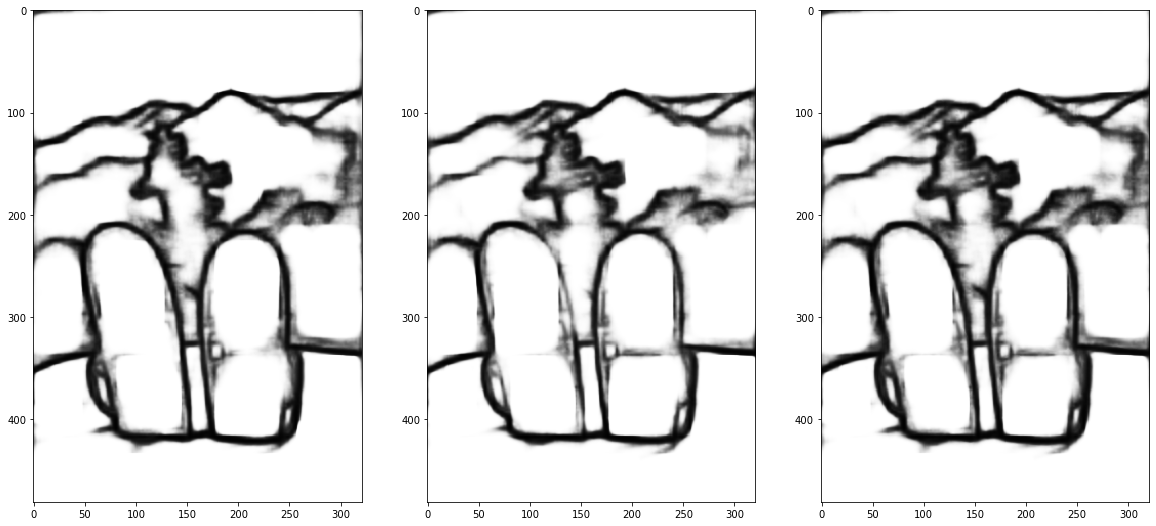

In [8]:
import numpy as np
from matplotlib import pyplot as plt

# combining of 2 (plain and transposed) outputs 
plt.figure(figsize=(20,20))
o1=outputs0[-2][0,:,:,0].T
o2=outputs1[-2][0,:,:,0]
o_mx=np.max(np.vstack([o1[None,],o2[None,]]),axis=0)
for num, im in enumerate([o1, o2, o_mx]):
    plt.subplot(1,3,num+1)
    plt.imshow(1-im, cmap='gray')

In [ ]:
# angles to orientations from model
I=np.array([out[0,:,:,0].T for out in outputs0[:-2]])
O=predicter_without_model.interpolate_angles(I)

# Open original orientations
import pickle
pkl_name='2018_or.pkl'
pkl_fl = r'../demo/{0}'.format(pkl_name)
with open(pkl_fl, "rb") as f:
    gradient_orientation = pickle.load(f) 

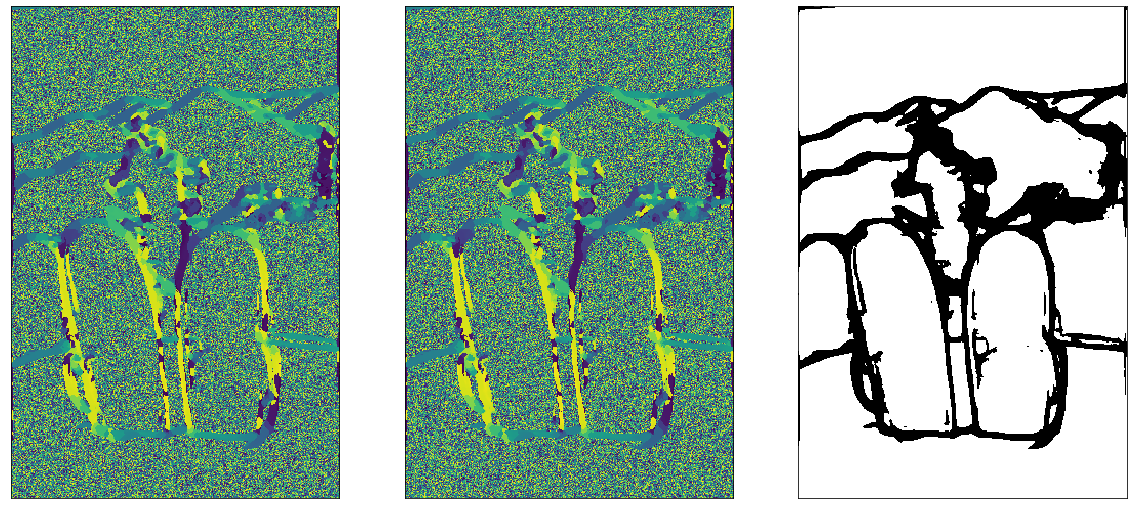

In [10]:
plt.figure(figsize=(20,20))

for num,im in enumerate([O,gradient_orientation,np.abs(O-gradient_orientation)]):
    plt.subplot(1,3,num+1)
    if num==2:        
        plt.imshow(im>1e-5, cmap='gray')
    else:
        plt.imshow(im)
    plt.xticks([])
    plt.yticks([])

In [10]:
# Open intermediate layers from native model
import pickle
with open(r"d:\virt_shared\moto_out_rev.pkl", "rb") as f:
    outputs_caffe = pickle.load(f, encoding="bytes") 

In [12]:
#getting output from specified layer
def get_tf_layer(input_image, model, lr_name):
    get_layer_output = tf.keras.backend.function([model.layers[0].input],
                                  [model.get_layer(lr_name).output])
    layer_output = get_layer_output(np.array([input_image]))[0]
    return layer_output


# Caffe section

In [ ]:
import caffe
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

base=r'/home/sgr/COB/models'
PRETRAINED = '{0}/COB_PASCALContext_trainval.caffemodel'.format(base)
MODEL_FILE = '{0}/deploy.prototxt'.format(base)

img = np.asarray(Image.open(r'/home/sgr/Загрузки/COB/demos/2010_005731.png'))

net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)
caffe.set_mode_cpu()

counter=0
for key in net.params:    
    num=net.params[key].__len__()
    out='{0:22}#{1:2}'.format(key, num)
    
    for i in range(num):
        sh=net.params[key][i].data[...].shape
#         out='{0}; {1:3} shape:{2:25}'.format(out, i, sh)
        out='{0};\t{1}: shape:{2:20}'.format(out, i+1, str(sh))
    counter+=1
    print(out)
print('Total params layer: '+str(counter))

In [6]:
mn=np.array([122.67891434, 116.66876762,104.00698793])
data=(img-mn)[:,:,[2,1,0]]
# data=np.transpose(data,axes=(1,0,2))
data=np.transpose(data,axes=(2,1,0))
# print([*data.shape])
net.blobs['data'].reshape(1, *data.shape)
net.blobs['data'].data[...]=data
res = net.forward()